In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from typing import List

# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.grid'] = True
# plt.rcParams.keys()

In [2]:
def cargar_datos(file_name : str, pow_measure = False) -> List[np.ndarray]:
    
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = np.array([np.mean(dic[offset]["V_2"])*1000 for offset in offs_values_keys])
    # Varianza de la corriente
    corr_err_values = np.array([np.std(dic[offset]["V_2"])*1000 for offset in offs_values_keys])
    # Verdaderos valores de continua
    offs_true_values = np.array([np.mean(dic[offset]["V_1"]) for offset in offs_values_keys])
    # Le sacamos la "V" a las keys
    offs_values = np.array([float(offset[:-1]) for offset in offs_values_keys])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values, corr_err_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

In [20]:
file_name = '../mediciones/D.D/Fotodetectores/Fotodetector B - Barrido offset.pickle'

dic = pickle.load(open(file_name, "rb"))

In [21]:
corr, V_fotodetector = [], []
for key in dic.keys():
    corr.append(np.mean(dic[key]["V_1"]))
    V_fotodetector.append(np.mean(dic[key]["V_2"]))

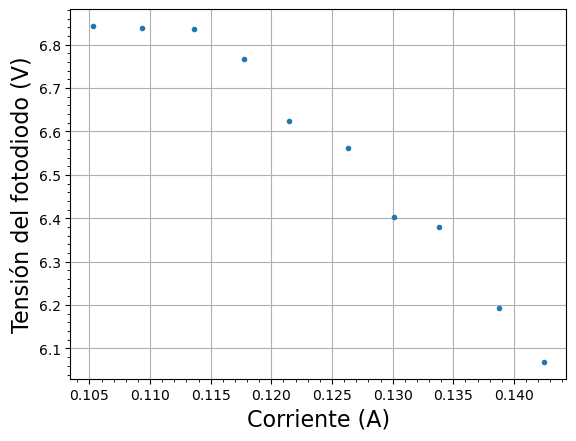

In [22]:
plt.plot(np.abs(corr),V_fotodetector,".")
plt.xlabel("Corriente (A)")
plt.ylabel("Tensión del fotodiodo (V)")
plt.show()